In [50]:
# install BigQuery_Helper from github
!pip install -e git+https://github.com/SohierDane/BigQuery_Helper#egg=bq_helper

Obtaining bq_helper from git+https://github.com/SohierDane/BigQuery_Helper#egg=bq_helper
  Updating ./src/bq-helper clone
  Running command git fetch -q --tags
  Running command git reset --hard -q 8615a7f6c1663e7f2d48aa2b32c2dbcb600a440f
  Found existing installation: bq-helper 0.4.1
    Can't uninstall 'bq-helper'. No files were found to uninstall.
  Running setup.py develop for bq-helper


In [51]:
# import reguired libraries
import pandas as pd
import numpy as np
from google.cloud import bigquery
from bq_helper import BigQueryHelper
# authentication
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [52]:
# loading needed extension from google colab
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [53]:
# set project id for access to the project on google cloud platform 
project_id = "project297814"
%env GCLOUD_PROJECT=project_id

env: GCLOUD_PROJECT=project_id


In [54]:
#setting parametersfor biqquery
client=bigquery.Client(project=project_id)

In [55]:
bq_assistant = BigQueryHelper("bigquery-public-data", "github_repos")
bq_assistant.client=bigquery.Client(project=project_id)

### Part One of the tutorial “Data stories for the 1000genome project”: Exploring The Phenotypic Data

In [56]:
q1 = '''
# Count the number of samples in the phenotypic data
SELECT
  COUNT(sample) AS all_samples,
  SUM(IF(In_Phase1_Integrated_Variant_Set = TRUE, 1, 0)) AS samples_in_variants_table
FROM
    `genomics-public-data.1000_genomes.sample_info`
'''

In [57]:
bq_assistant.estimate_query_size(q1)

3.0353665351867676e-05

In [58]:
df = bq_assistant.query_to_pandas(q1)

In [59]:
df

,all_samples,samples_in_variants_table
0,3500,1092


In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import numpy as np

<function matplotlib.pyplot.show>

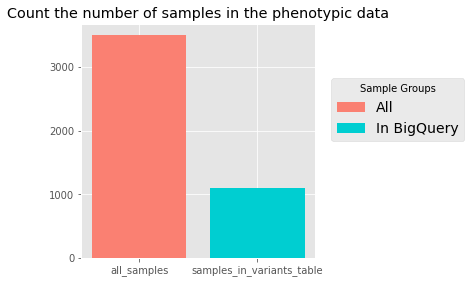

In [61]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_axes([0,0,0.65,0.65])
plt.bar(list(df)[0], height=[j for sub in df.values.tolist() for j in sub][0], color="salmon", label='All')
plt.bar(list(df)[1], height=[j for sub in df.values.tolist() for j in sub][1], color="darkturquoise", label='In BigQuery')
plt.title('Count the number of samples in the phenotypic data')
ax.set_yticks(np.arange(0, 4000, 1000))
fig.legend(title='Sample Groups', loc=(0.7, 0.5), fontsize=14)
plt.show

So for analyses across all samples upon table `variants`, the sample size is 1,092.
What is the gender ratio?

In [62]:
q2 = '''
# Compute sample count and ratio by gender
SELECT
  gender,
  gender_count,
  (gender_count/total) AS gender_ratio,
FROM (
  SELECT
    gender,
    COUNT(gender) AS gender_count,
    SUM(COUNT(gender)) OVER() AS total
  FROM
    `genomics-public-data.1000_genomes.sample_info`
  WHERE
    In_Phase1_Integrated_Variant_Set = TRUE
  GROUP BY
    gender)
  ORDER BY
    gender_count
'''

In [63]:
bq_assistant.estimate_query_size(q2)

2.3853033781051636e-05

In [64]:
df = bq_assistant.query_to_pandas(q2)

In [65]:
df

,gender,gender_count,gender_ratio
0,male,525,0.480769
1,female,567,0.519231


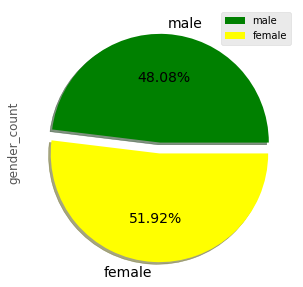

In [66]:
plot = df.plot.pie(y='gender_count', figsize=(5, 5), labels=[j for sub in df[['gender']].values.tolist() for j in sub], explode=(0,0.1), shadow=True, colors=['green','yellow'], autopct='%1.2f%%', fontsize=14 )

In [67]:
q3 = '''
# Compute sample count and ratio by ethnicity
SELECT
  population,
  population_description,
  population_count,
  (population_count/total) as population_ratio,
  super_population,
  super_population_description,
from(
  SELECT
    population,
    population_description,
    super_population,
    super_population_description,
    COUNT(population) AS population_count,
    SUM(COUNT(population)) OVER() AS total,
  FROM
    `genomics-public-data.1000_genomes.sample_info`
  WHERE
    In_Phase1_Integrated_Variant_Set = TRUE
  GROUP BY
    population,
    population_description,
    super_population,
    super_population_description)
  ORDER BY population_count

'''

In [68]:
bq_assistant.estimate_query_size(q3)

0.0001673717051744461

In [69]:
df = bq_assistant.query_to_pandas(q3)

In [70]:
df

,population,population_description,population_count,population_ratio,super_population,super_population_description
0,IBS,Iberian populations in Spain,14,0.012821,EUR,European
1,PUR,Puerto Rican in Puerto Rico,55,0.050366,AMR,American
2,CLM,"Colombian in Medellin, Colombia",60,0.054945,AMR,American
3,ASW,African Ancestry in Southwest US,61,0.055861,AFR,African
4,MXL,"Mexican Ancestry in Los Angeles, California",66,0.060440,AMR,American
5,CEU,Utah residents with Northern and Western Europ...,85,0.077839,EUR,European
6,YRI,"Yoruba in Ibadan, Nigeria",88,0.080586,AFR,African
7,GBR,British in England and Scotland,89,0.081502,EUR,European
8,JPT,"Japanese in Tokyo, Japan",89,0.081502,EAS,East Asian
9,FIN,Finnish in Finland,93,0.085165,EUR,European


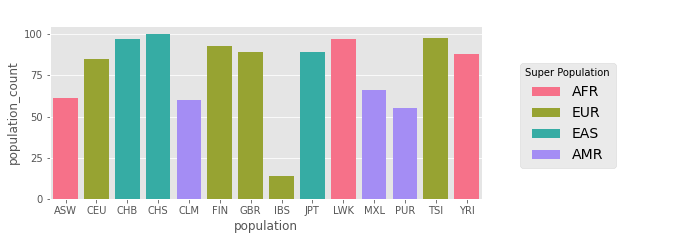

In [71]:
import seaborn as sns
df=df.sort_values(by="population", ascending=True)
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0,0,0.6,0.6])
sns.barplot(y='population_count', x='population', hue='super_population', data=df, palette="husl", saturation=.99, dodge=False)
ax.get_legend().set_visible(False)
ax.set_yticks(np.arange(0, 110, 25))
fig.legend(title='Super Population', loc=(0.75, 0.3), fontsize=14)
plt.show()


In [72]:
q4='''
# Ratios of ethnicities grouped by super population
SELECT
  super_population,
  super_population_description,
  super_population_count,
  (super_population_count/total) AS super_population_ratio
from(
  SELECT
    super_population,
    super_population_description,
    COUNT(population) AS super_population_count,
    SUM(COUNT(population)) OVER() AS total,    
  FROM
    `genomics-public-data.1000_genomes.sample_info`
  WHERE
    In_Phase1_Integrated_Variant_Set = TRUE
  GROUP BY
    super_population,
    super_population_description)
  ORDER BY
    super_population_count
'''

In [73]:
bq_assistant.estimate_query_size(q4)

6.825756281614304e-05

In [74]:
df = bq_assistant.query_to_pandas(q4)

In [75]:
df

,super_population,super_population_description,super_population_count,super_population_ratio
0,AMR,American,181,0.165751
1,AFR,African,246,0.225275
2,EAS,East Asian,286,0.261905
3,EUR,European,379,0.347070


In [76]:
df.loc[0].at['super_population_ratio']

0.16575091575091574

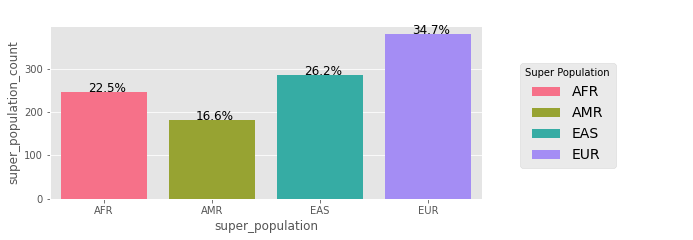

In [77]:
import seaborn as sns
df=df.sort_values(by="super_population", ascending=True)
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0,0,0.6,0.6])
sns.barplot(y='super_population_count', x='super_population', hue='super_population', data=df, palette="husl", saturation=.99, dodge=False)
ax.get_legend().set_visible(False)
ax.set_yticks(np.arange(0, 400, 100))
fig.legend(title='Super Population', loc=(0.75, 0.3), fontsize=14)

def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/(np.nansum(np.array(a))*total))
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)
with_hue(ax, df.super_population_count, 4, 4)
plt.show()

In [78]:
q5='''
# Ratios of ethnicities grouped by gender
SELECT
  population,
  gender,
  population_count,
  (population_count/total) AS population_ratio
from(
  SELECT
    gender,
    population,
    COUNT(population) AS population_count,
    SUM(COUNT(population)) OVER(PARTITION BY population) AS total, 
  FROM
    `genomics-public-data.1000_genomes.sample_info`
  WHERE
    In_Phase1_Integrated_Variant_Set = TRUE
  GROUP BY
    gender,
    population)
ORDER BY
  population,
  gender
  '''

In [79]:
bq_assistant.estimate_query_size(q5)

4.015117883682251e-05

In [80]:
df = bq_assistant.query_to_pandas(q5)

In [81]:
df

,population,gender,population_count,population_ratio
0,ASW,female,37,0.606557
1,ASW,male,24,0.393443
2,CEU,female,40,0.470588
3,CEU,male,45,0.529412
4,CHB,female,53,0.546392
5,CHB,male,44,0.453608
6,CHS,female,50,0.500000
7,CHS,male,50,0.500000
8,CLM,female,31,0.516667
9,CLM,male,29,0.483333


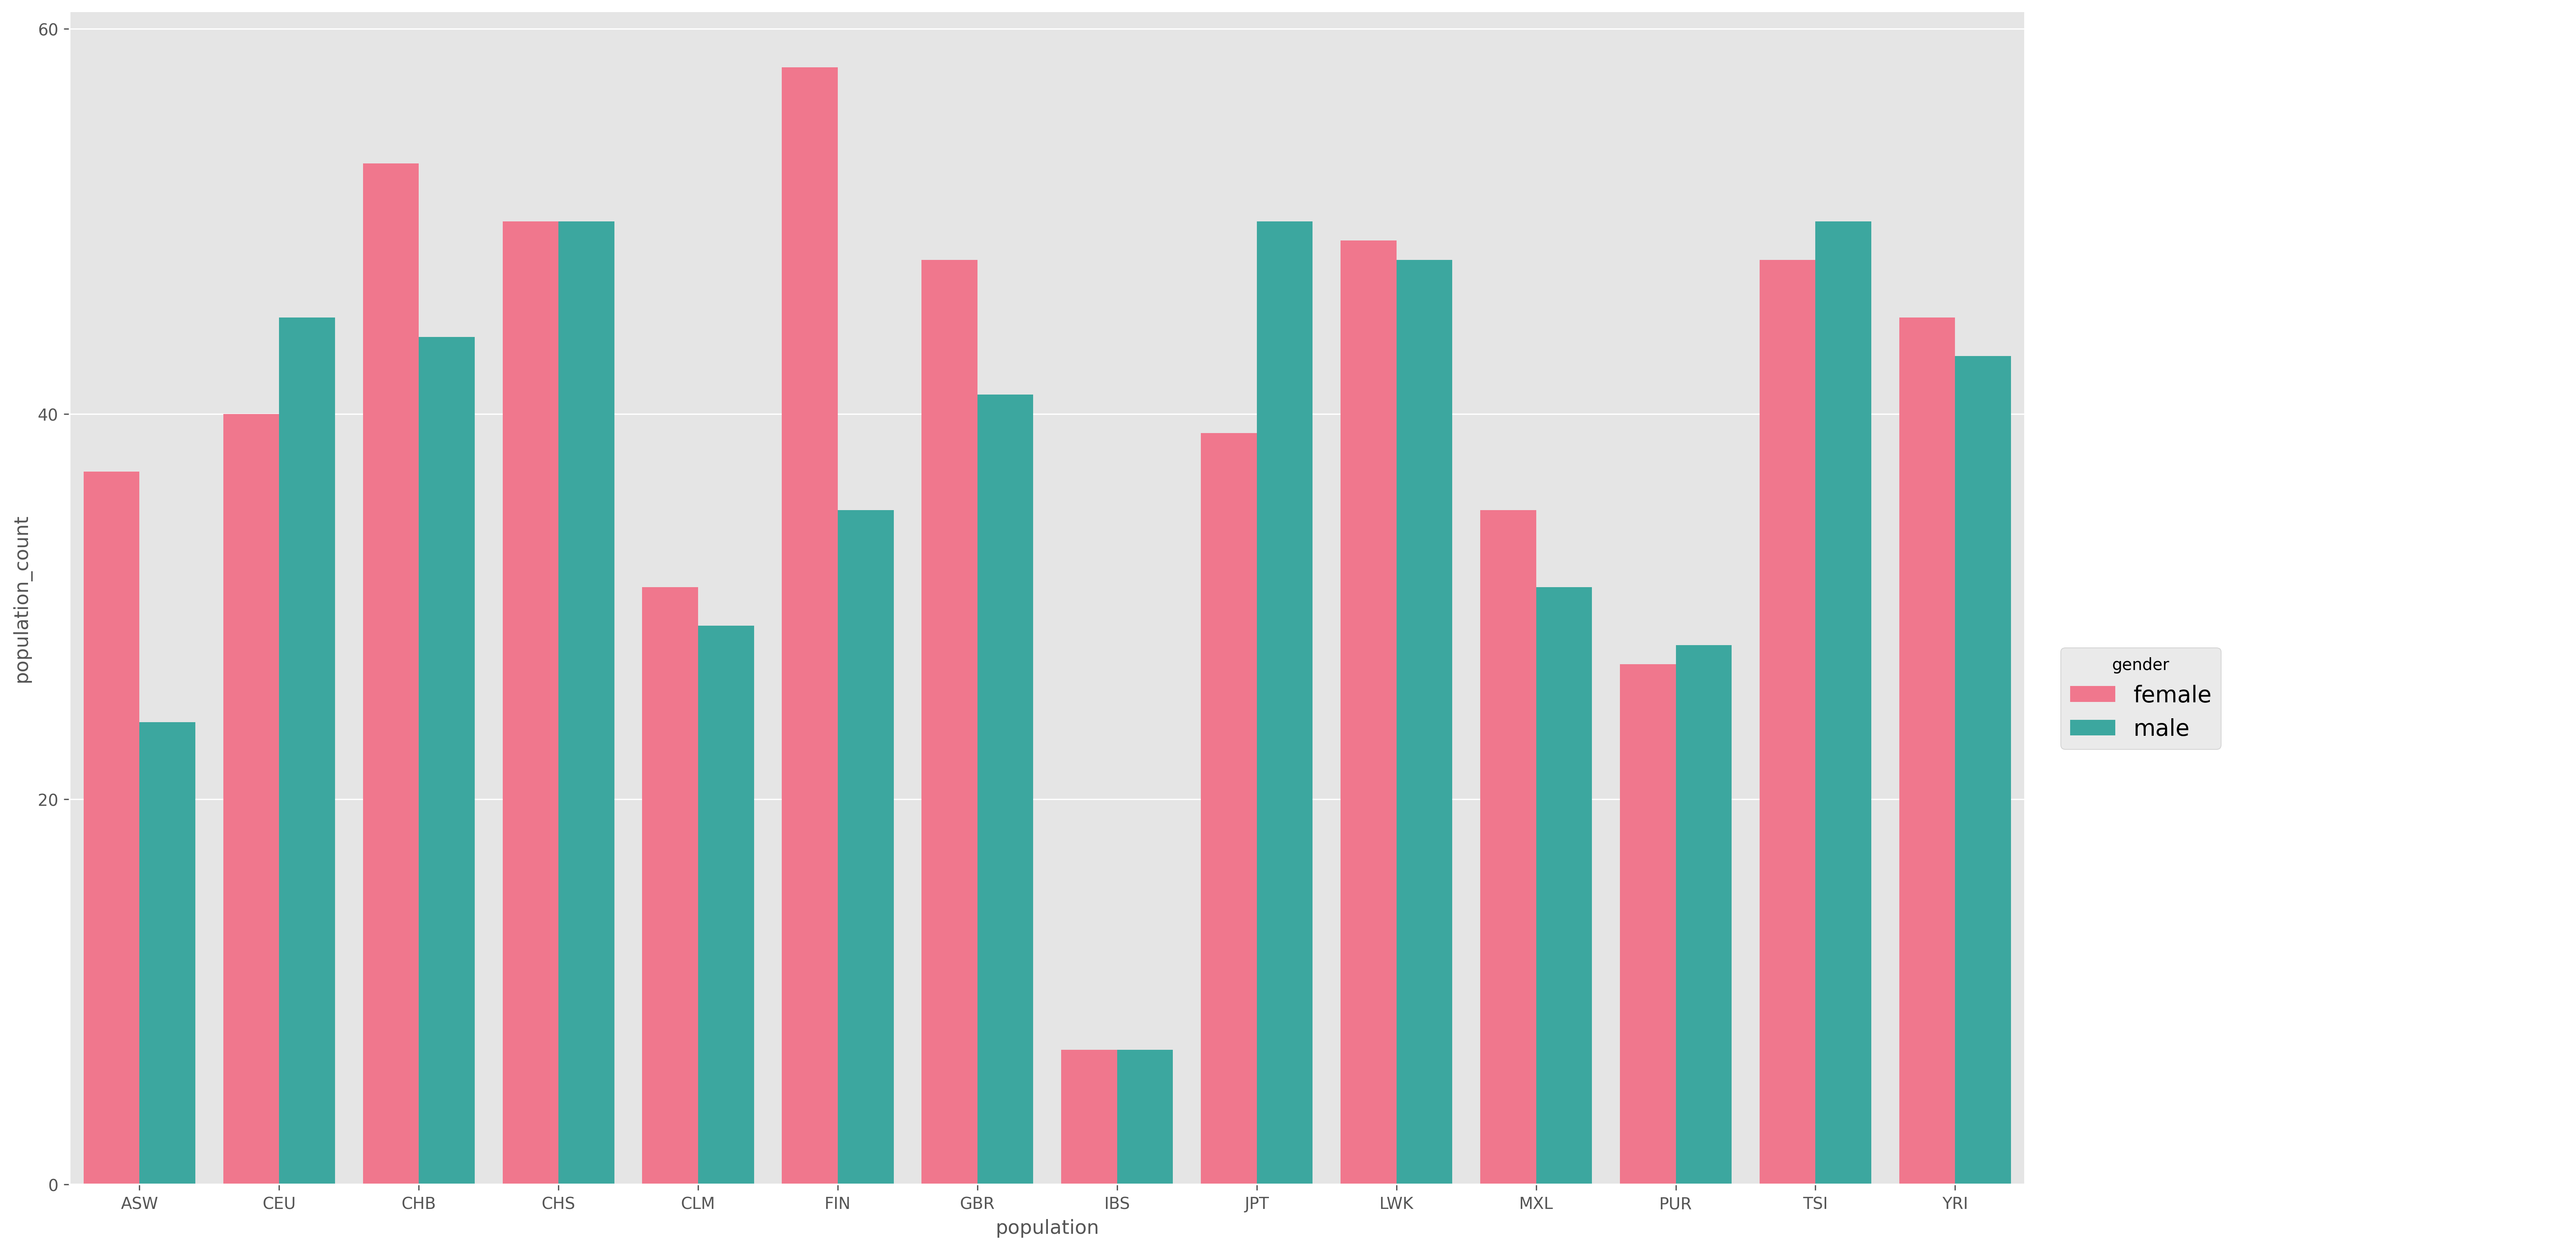

In [85]:
df=df.sort_values(by="population", ascending=True)
fig = plt.figure(figsize=(25,15), dpi=300)
ax = fig.add_axes([0,0,0.67,0.67])
sns.barplot(x='population', y='population_count', hue='gender', data=df, palette="husl", saturation=.9)
ax.get_legend().set_visible(False)
ax.set_yticks(np.arange(0, 70, 20))
fig.legend(title='gender', loc=(0.8, 0.4), fontsize=14)

plt.show()

In [34]:
q6='''
# Compute the distribution of family sizes
SELECT
num_family_members AS family_size,
COUNT(num_family_members) AS num_families_of_size
FROM (
  SELECT
  family_id,
  COUNT(family_id) AS num_family_members,
  FROM
    `genomics-public-data.1000_genomes.sample_info`
  WHERE
  In_Phase1_Integrated_Variant_Set = TRUE
  GROUP BY
  family_id)
GROUP BY
family_size
  '''

In [35]:
bq_assistant.estimate_query_size(q6)

2.4281442165374756e-05

In [36]:
df = bq_assistant.query_to_pandas(q6)

In [37]:
df

,family_size,num_families_of_size
0,1,636
1,2,204
2,3,12
3,4,3


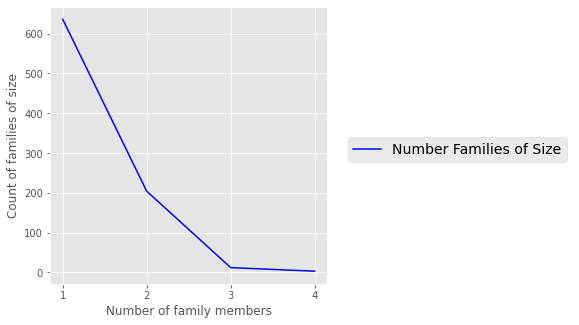

In [38]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0,0,0.55,0.55])
plt.plot(df['family_size'], df['num_families_of_size'], color='blue', label="Number Families of Size")
ax.set_xticks(np.arange(1, 5, 1))
ax.set_xlabel("Number of family members")
ax.set_ylabel("Count of families of size")
fig.legend(loc=(0.6, 0.5), fontsize=14)

### Part Two of the tutorial “Data stories for the 1000genome project”: Exploring The Variant Data

In [39]:
q7='''
SELECT
  SAFE_CAST(reference_name AS INT64) AS chromosome,
   MIN(start) AS min,
   MAX(start) AS max
 FROM
    `genomics-public-data.1000_genomes.variants`
 WHERE
   reference_name<"X"   AND    reference_name <"Y"   AND    reference_name <"MT"
 GROUP BY
   chromosome
'''

In [40]:
bq_assistant.estimate_query_size(q7)

0.42134151980280876

In [41]:
df = bq_assistant.query_to_pandas(q7)

In [42]:
df

,chromosome,min,max
0,16,60053,90292810
1,20,60478,62965161
2,3,60156,197946620
3,13,19020012,115109851
4,12,61106,133841509
5,4,10239,191043592
6,19,80839,59118837
7,21,9411242,48119750
8,18,10643,78017156
9,15,20001199,102520964


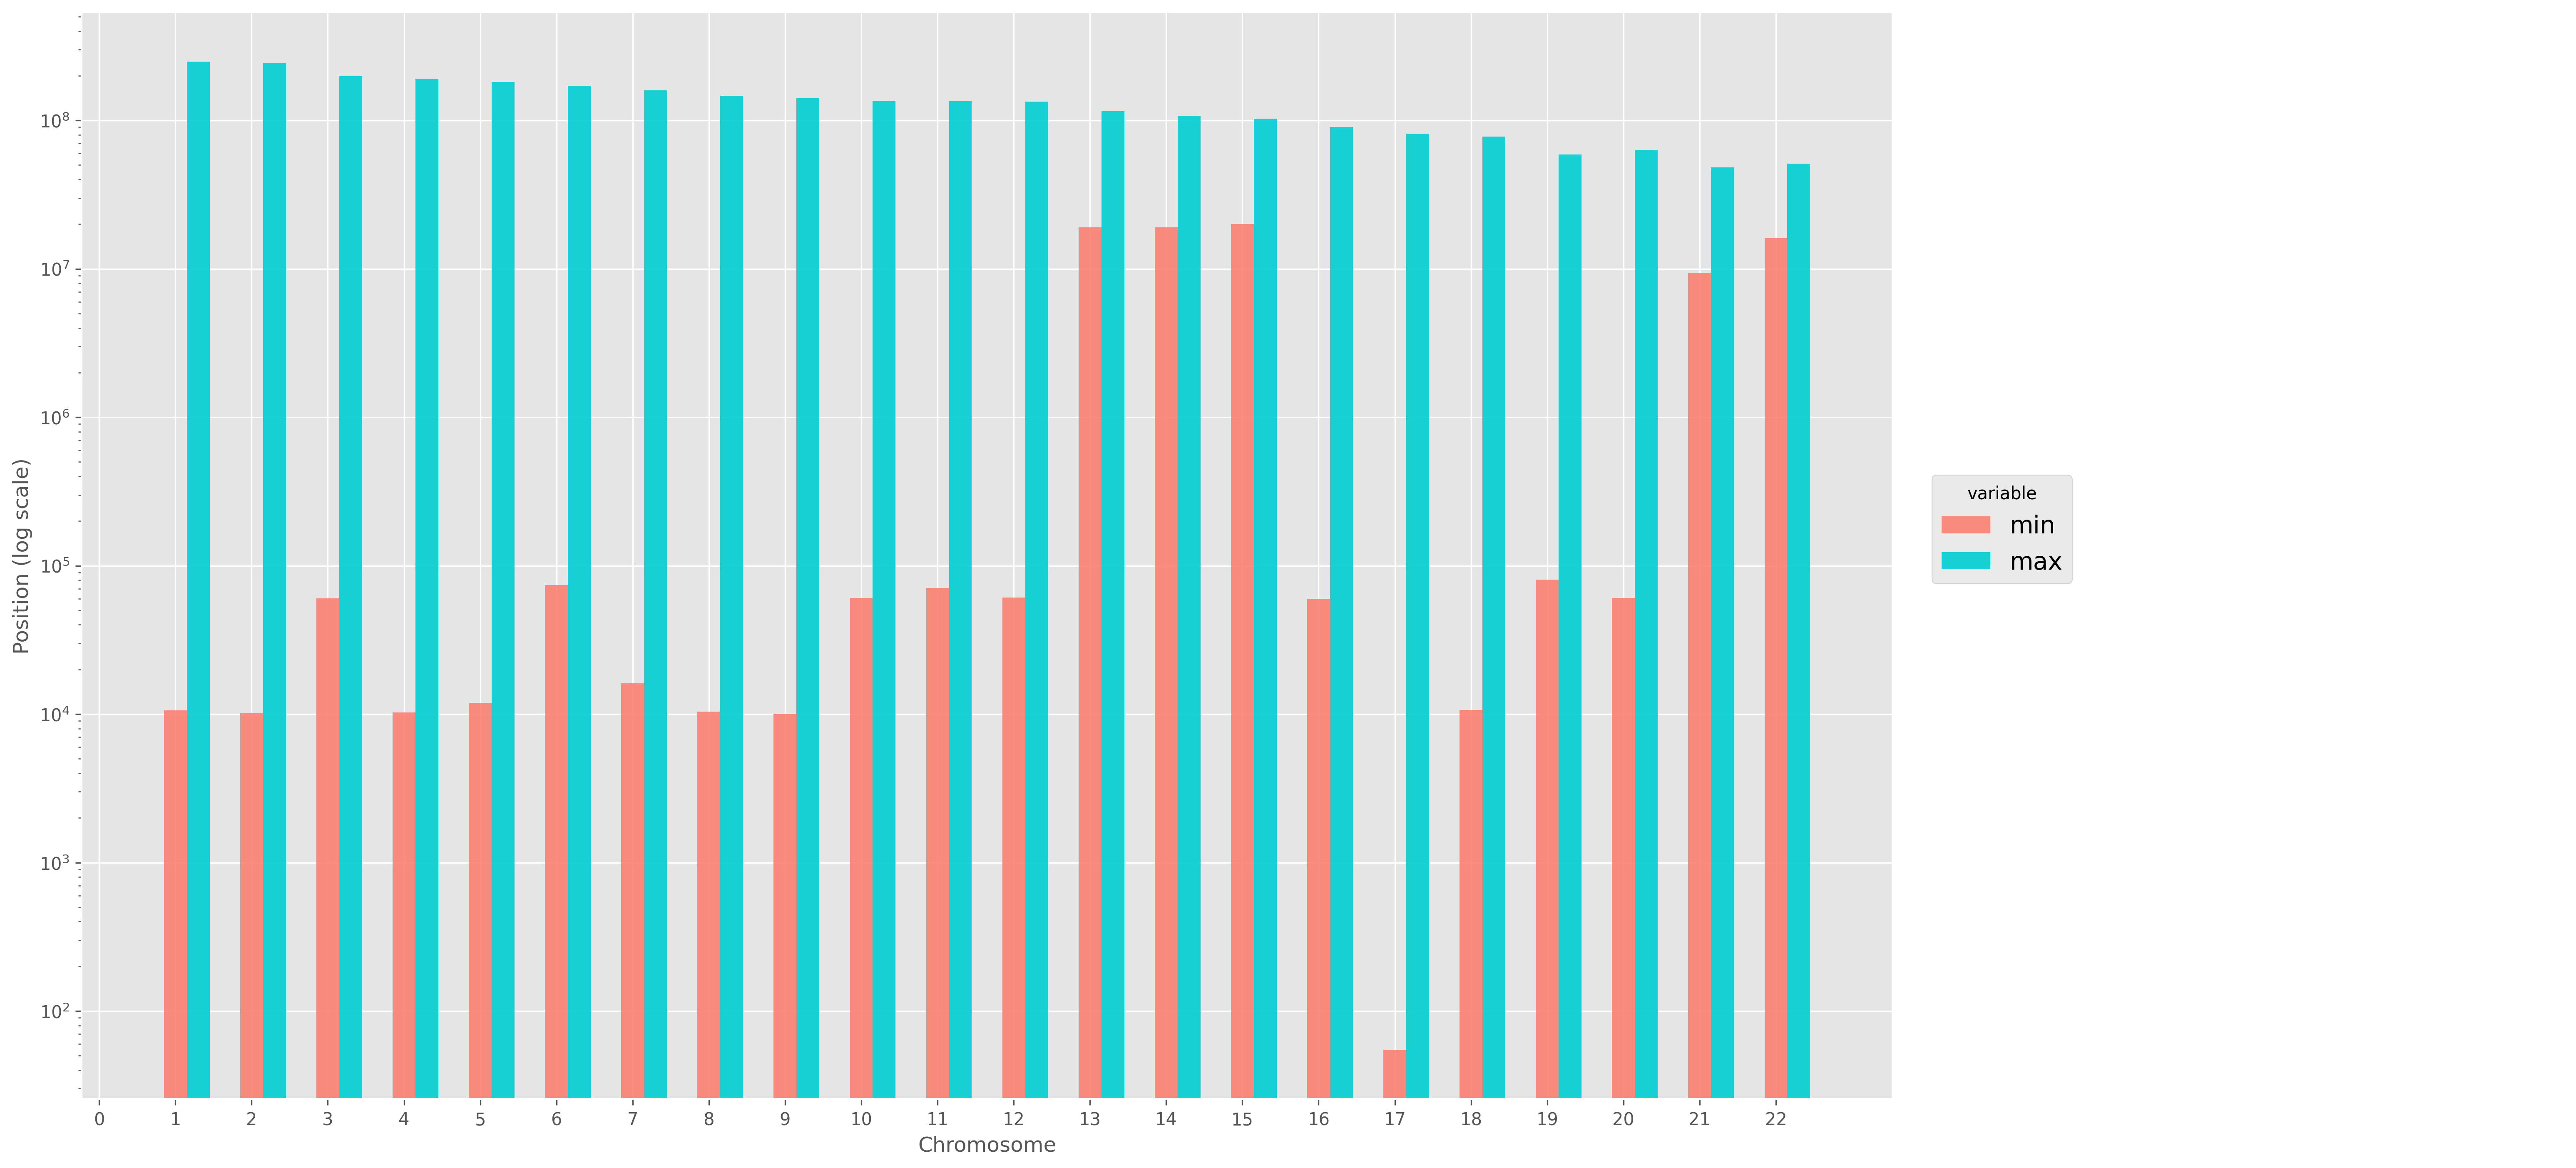

In [43]:
#df['chromosome']=df['chromosome'].apply(pd.to_numeric)
df.sort_values(by="chromosome", ascending=True)
fig = plt.figure(figsize=(25,15), dpi=300)
ax = fig.add_axes([0,0,0.58,0.58])
n = 5
index = df['chromosome'].values
bar_width = 0.3
opacity = 0.9
ax.bar(index, df['min'].values, bar_width, alpha=opacity, color='salmon', label='min')
ax.bar(index+bar_width, df['max'].values, bar_width, alpha=opacity, color='darkturquoise', label='max')
ax.set_xlabel('Chromosome')
ax.set_yscale('log')
ax.set_xticks(np.arange(0, len(index)+bar_width, 1))

ax.set_ylabel('Position (log scale)')
fig.legend(title='variable', loc=(0.75, 0.5), fontsize=14)

plt.show()

In [44]:
q8='''
SELECT
  SAFE_CAST(reference_name AS INT64) AS chromosome,
  vt AS variant_type,
  COUNT(1) AS cnt
 FROM
    `genomics-public-data.1000_genomes.variants`
 WHERE
   reference_name<"X"   AND    reference_name <"Y"   AND    reference_name <"MT"
 GROUP BY
   chromosome,
   variant_type
   '''

In [45]:
bq_assistant.estimate_query_size(q8)

0.31291691306978464

In [46]:
df = bq_assistant.query_to_pandas(q8)

In [47]:
df

,chromosome,variant_type,cnt
0,15,SV,417
1,14,SV,467
2,8,SNP,2111368
3,5,SNP,2438833
4,20,INDEL,29871
...,...,...,...
61,3,SNP,2664001
62,15,SNP,1088959
63,17,SNP,1007119
64,14,INDEL,46775


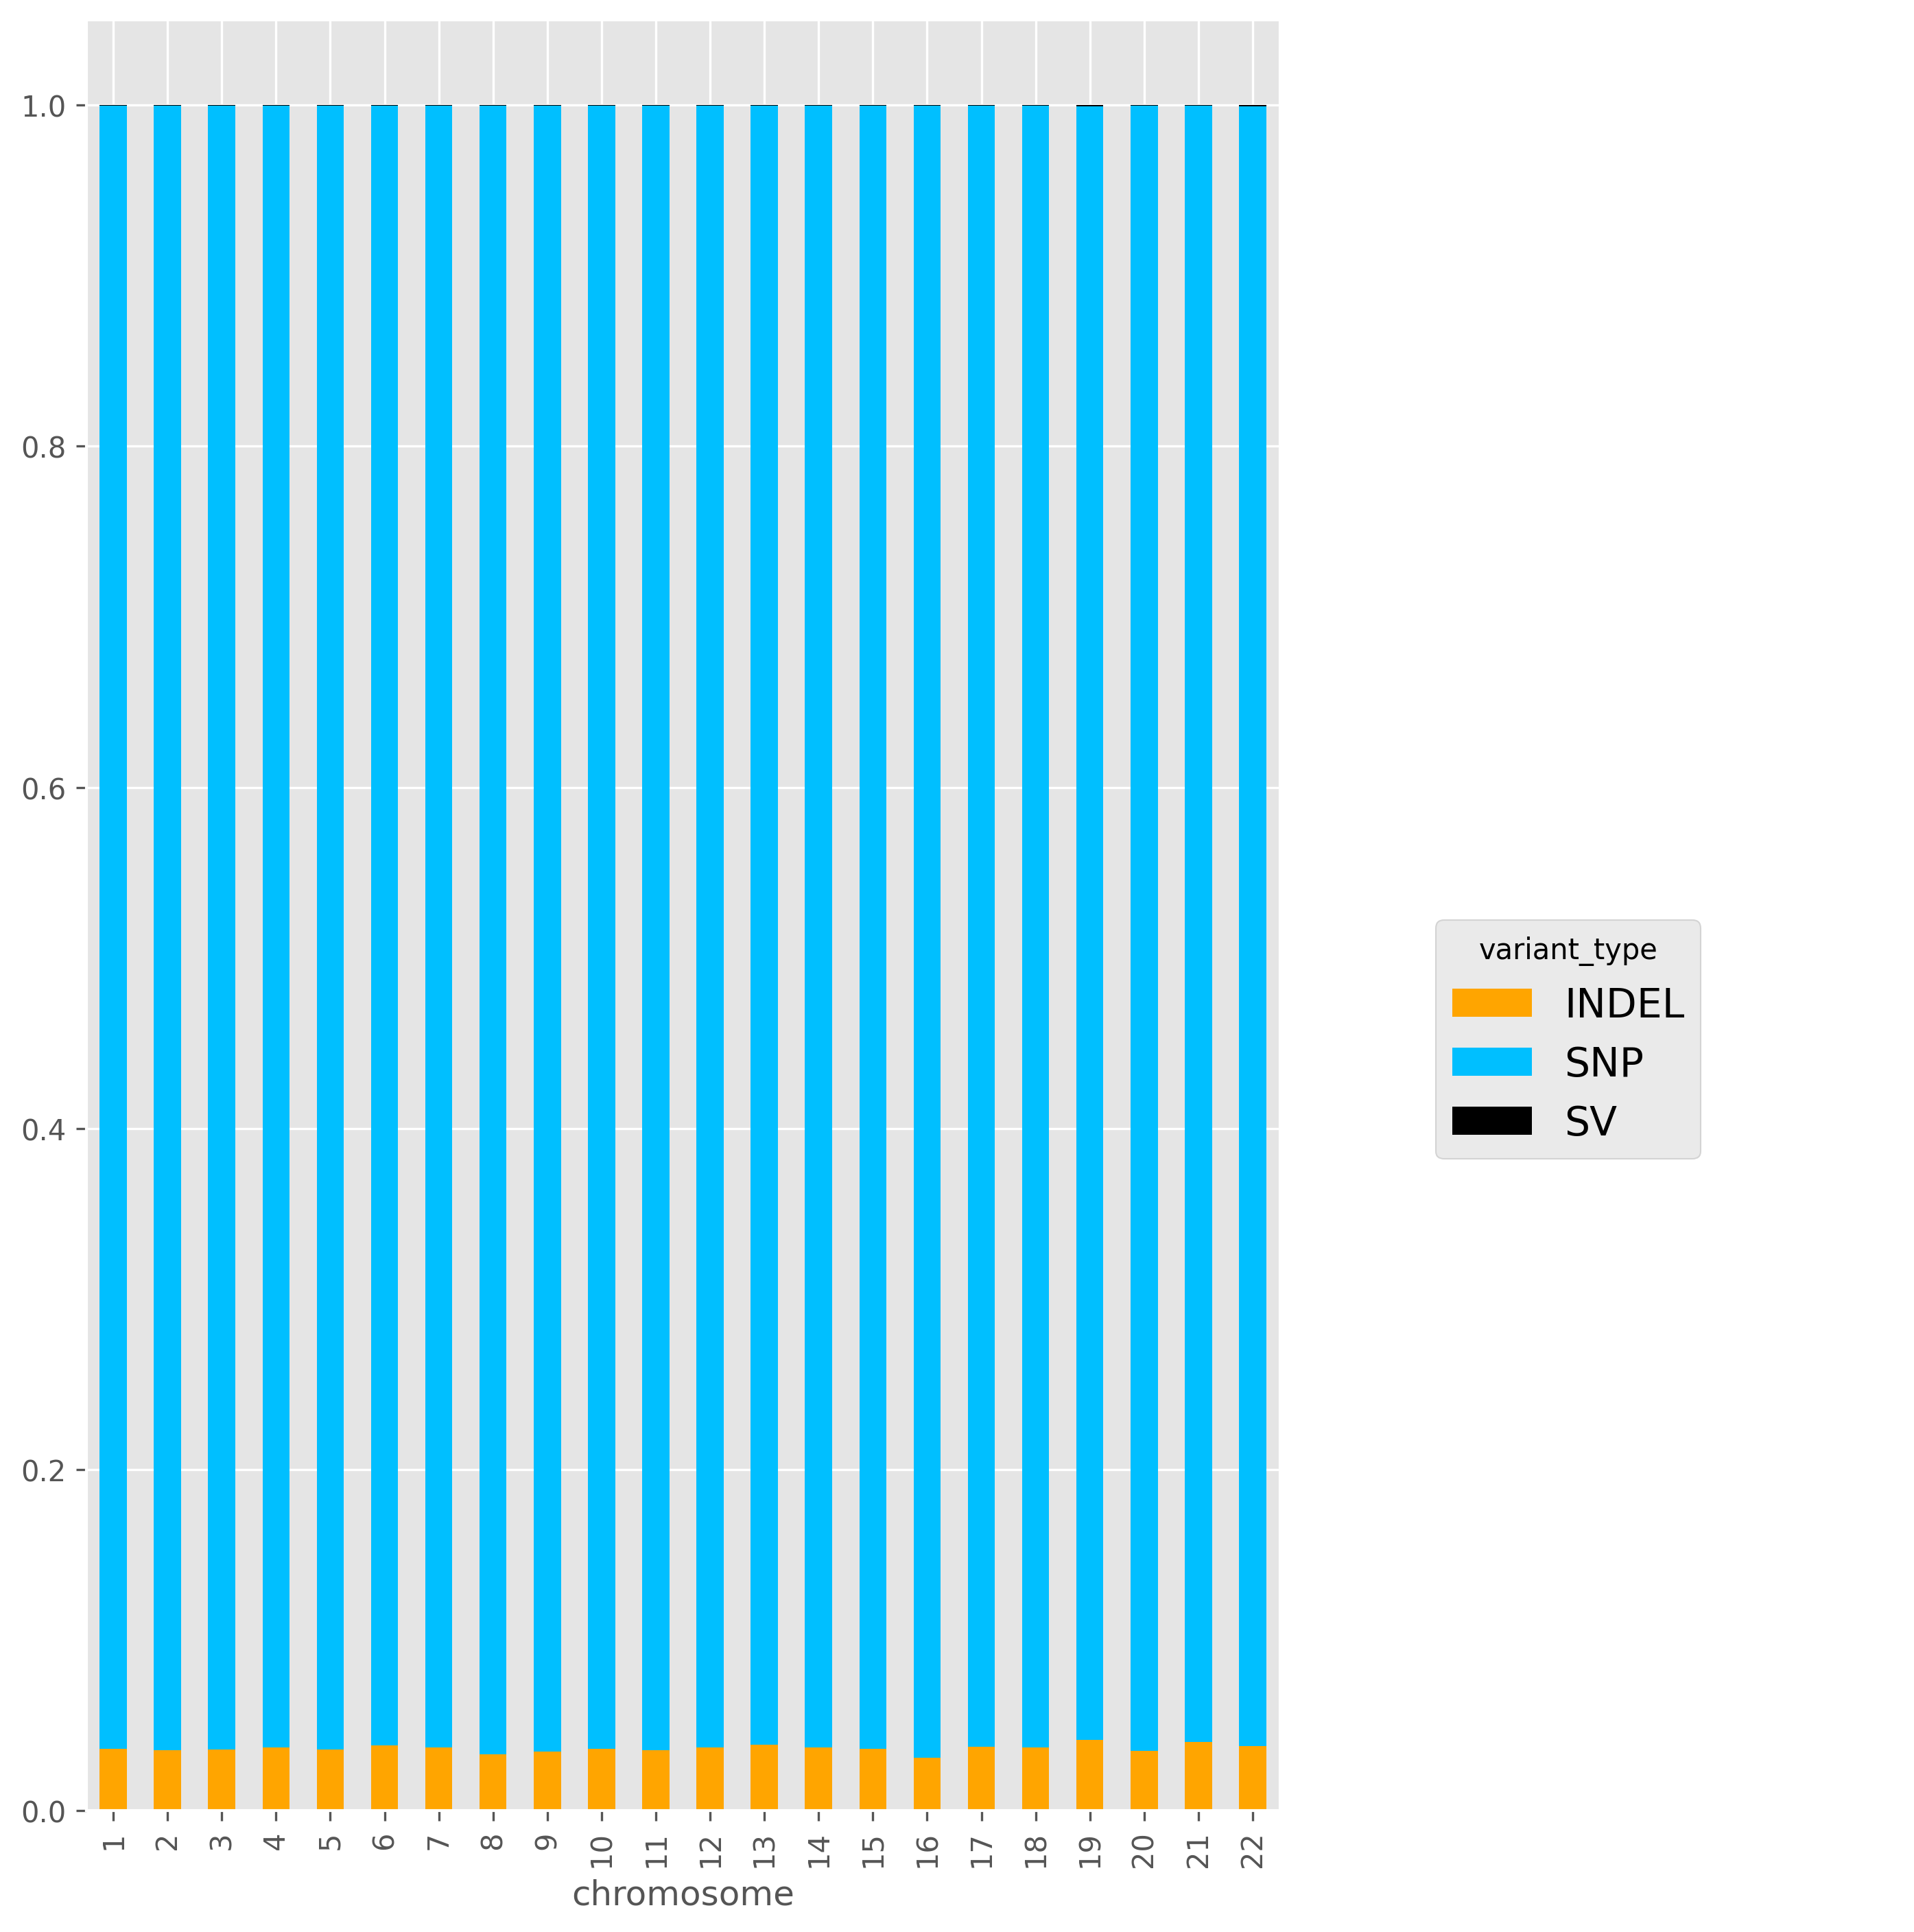

In [48]:
df_pct = (df.groupby(['chromosome','variant_type'])['cnt'].sum()/df.groupby(['chromosome'])['cnt'].sum())
fig = plt.figure(figsize=(10,15), dpi=300)
ax = fig.add_axes([0,0,0.58,0.58])  
df_pct.unstack().plot.bar(stacked=True, color=["orange", "deepskyblue","black"], ax=ax)
ax.get_legend().set_visible(False)
fig.legend(title='variant_type', loc=(0.75, 0.4), fontsize=14)